In [4]:
using ReactiveMP, Rocket, GraphPPL
using Random, Distributions, Plots, LinearAlgebra
using KernelFunctions

## Solve GP regression by SDE 
In this notebook, we try to solve a GP regression problem by using SDE (ref: Solin, Arno. "Stochastic differential equation methods for spatio-temporal Gaussian process regression." (2016).) 

The kernel we use is Matern-3/2


## State space model

In [2]:
# @model function gp_regression(n, A, Q, H)
#     f_0 ~ MvNormalMeanCovariance([0., 0.], P∞)

#     f = randomvar(n)
#     y = datavar(Float64,n)

#     f_prev = f_0
#     for i=1:n
#         f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
#         y[i] ~ NormalMeanVariance(dot(H , f[i]), 0.2)
#         f_prev = f[i]
#     end

#     return f, y
# end

In [30]:
@model function gp_regression(n, t_obser, t, θ)
    Δt = [t[1]]; #This stores time differences
    append!(Δt, t[2:end] - t[1:end-1]);
    T = length(t); # t is the whole timeline

    λ = sqrt(3.)/θ[1];
    P∞ = [θ[2] 0.; 0. (λ^2*θ[2]) ]
    F = [0. 1.; -λ^2 -2*λ];
    H = [1.; 0.];


    f_0 ~ MvNormalMeanCovariance([0., 0.], P∞)
    f = randomvar(T)
    y = datavar(Float64,n)
    f_prev = f_0

    for i=1:T
        if i < T 
        #check if we have observation at this time step
            if t[i] in t_obser
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                #find position of t[i] in t_obser 
                position = findall(x->x==t[i], t_obser)[]
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                y[position] ~ NormalMeanVariance(dot(H , f[i]), θ[3])
                f_prev = f[i]
            else
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                f_prev = f[i]
            end
        else
            if t[i] in t_obser
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                #find position of t[i] in t_obser 
                position = findall(x->x==t[i], t_obser)[]
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                y[position] ~ NormalMeanVariance(dot(H , f[i]), θ[3])
                f_prev = f[i]
            else
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                f[i] ~ Uninformative()
            end
        end
    end

    return f, y
end

## Inference

In [31]:
function infer(data,t_obser, t,θ)
    n = length(data)
    model, (f,y) = gp_regression(n,t_obser, t,θ)
    
    f_buffer = buffer(Marginal, length(t)) #error here (maybe)

    f_subscribed = subscribe!(getmarginals(f), f_buffer) #error here

    update!(y,data)

    unsubscribe!(f_subscribed)

    return f_buffer
end

infer (generic function with 1 method)

## Generate data

In [75]:
#generate data
Random.seed!(10)
timeline = collect(range(0, 5, length=100)); #input
f_true = 2*sin.(timeline) .+ cos.(2*timeline); # true process

pos = sort(randperm(75)[1:2:75]); # position where we observe data
#append!(pos,length(timeline))
#pos = collect(1:2:100)
time_obser = timeline[pos]; # x-positions of observed point
y_obser = f_true[pos] + 0.2*randn(length(time_obser)); # noisy observation

θ = [1., 1., 0.2]; # store [l, σ², σ²_noise]
# λ = sqrt(3.)/θ[2];
# P∞ = [θ[3] 0.; 0. (λ^2*θ[3]) ]
# F = [0. 1.; -λ^2 -2*λ];
# A = exp(F * θ[1]); # this depends on Δt
# H = [1.; 0.];
# Q = P∞ - A*P∞*A';

In [69]:
#Addtitional rule for MvNormalMeanCovariance
@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::Missing, q_Σ::PointMass, ) = begin 
    return missing 
end

#Additional rule for multiplication
@rule typeof(*)(:in, Marginalisation) (m_out::Missing, m_A::PointMass, meta::TinyCorrection) = begin 
    return missing 
end

## Execution

In [76]:
f_posterior = infer(y_obser, time_obser, timeline, θ);

In [78]:
m_f = Array{Array{Float64}}(undef, length(timeline))
cov_f = Array{Array{Float64}}(undef, length(timeline))
for i=1:length(timeline)
    m_f[i] = mean_cov.(f_posterior)[i][1]
    cov_f[i] = mean_cov.(f_posterior)[i][2]
end

M_F = hcat(m_f...);

In [79]:
var_f = []
for i=1:length(timeline)
    append!(var_f,cov_f[i][1])
end

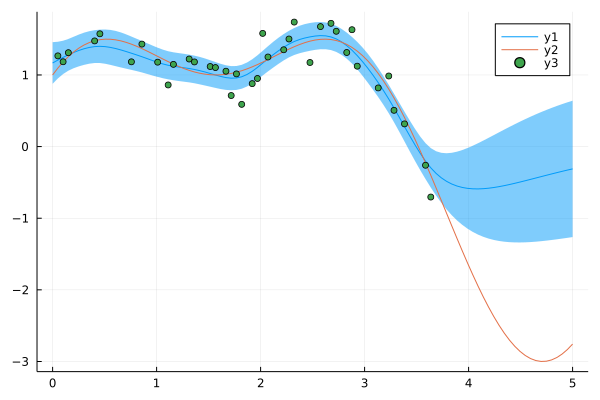

In [80]:
plot(timeline, M_F[1,:], ribbon = sqrt.(var_f))
plot!(timeline,f_true)
scatter!(time_obser,y_obser)